In [1]:
using Pkg
Pkg.activate(".")

using JLD2, Plots, Lux, QuadGK, ComponentArrays, PhasorNetworks

  Activating project at `~/code/phasor_julia`


# Load the test data

In [2]:
include("train_classifier.jl")
data_dir = "pixel_data/"
file_pairs = get_dataset(data_dir)

  Activating project at `~/code/phasor_julia`


10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [4]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [5]:
n_test = 10000

10000

In [6]:
q = q_test[:, :, :, 1:n_test]
yl = ylocal_test[1:n_test]
pt = pt_test[1:n_test];

# Load the trained networks

## Multilayer Perceptrons

In [7]:
ids = 43:48 |> collect;

In [8]:
function auroc(trained, call_fn)
    global pt
    pth = call_fn(trained)
    roc = tpr_fpr(pth, pt)
    roc_u = average_duplicate_knots(roc[2], roc[1])
    roc_fn = linear_interpolation(roc_u...)
    auroc = quadgk(roc_fn, 0.0, 1.0)[1]
    return auroc
end

auroc (generic function with 1 method)

In [9]:
mlps = [load("trained_nns/mlp_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (scale = Float32[0.84043115, 1.2591363, 1.7509029, 1.6067656, 1.2224876, 1.183681, 1.3597107, 1.7909936, 1.9222077, 0.5121033, 0.35439044, 0.46825647, 0.15563248, 0.60759217], bias = Float32[-0.15679184, 0.007983687, 0.34967747, 0.5587814, 0.54680705, 0.6282297, 0.58878344, 0.371983, 0.020967497, -0.30517352, -0.24793093, -0.03700212, -0.32763767, 0.07363863]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.26534644 0.16762076 … 0.2233943 0.8040235; 0.114862956 0.055006634 … -0.1330096 -0.5745751; … ; -0.26862222 0.023581494 … -0.15008631 -0.49673986; -0.030385466 0.08127815 … -0.052740205 -0.410357], bias = Float32[0.11983151; 0.2736901; … ; 0.14855553; -0.056346085;;]), layer_4 = (weight = Float32[-0.91825676 -0.09599364 … -0.008247511 -0.18569079; 0.28259072 0.5849801 … 0.5030338 -0.36946005; 0.15059568 -0.26762253 … -0.3119786 0.25879323], bias = Float32[0.025180005; 0.09040724; -0.048583783;;])), "state" => (la

In [10]:
function predict_mlp(trained)
    params = trained["params"]
    state = trained["state"]
    global q
    global yl

    pred, _ = mlp_model(process_inputs_mlp(q, yl), params, state)
    return pred
end

predict_mlp (generic function with 1 method)

In [11]:
pth = predict_mlp(mlps[1])

3×10000 Matrix{Float64}:
 -1.03936  -1.2827    -1.36365   …  -1.17661   -1.94372   -0.867384
 -1.20626  -0.365469   1.2509        0.156264  -0.174552   0.85686
  1.5732    1.06693   -0.822588      1.63345    1.201      0.590607

In [12]:
auroc_mlp = x -> auroc(x, predict_mlp)

#67 (generic function with 1 method)

In [13]:
auroc_mlps = auroc_mlp.(mlps)

6-element Vector{Float64}:
 0.8619534200418385
 0.8643762766615558
 0.8537256897336294
 0.8663365019548579
 0.8657329658315501
 0.857021721103633

## Phasor MLPs

In [14]:
pmlps = [load("trained_nns/pmlp_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (scale = Float32[0.4611713, 0.7945772, 1.0455916, 0.9466239, 0.9983645, 0.7986385, 1.0625937, 1.076156, 1.085038, 0.17968072, 0.21605618, 0.16161042, 0.089231364, 0.3393442], bias = Float32[-0.30808827, 0.103240624, 0.27551818, 0.5620901, 0.28622818, 0.5678, 0.15927714, 0.38617665, -0.0020063354, 0.12638877, -0.105870426, -0.116136976, 0.027554784, 0.33653456]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.05868069 -0.034977213 … 0.44358674 0.27405196; 0.10406588 0.0152126 … 0.019462781 -0.17392358; … ; -0.05868901 0.17384061 … 0.021038758 -0.031678833; -0.20989293 0.22455822 … -0.078325585 0.09693501], bias = ComplexF32[0.97786313f0 + 0.024052907f0im, 1.000072f0 + 0.0338428f0im, 0.89760166f0 + 0.086402066f0im, 0.98783225f0 - 0.013903405f0im, 1.0128567f0 + 0.009071913f0im, 0.96993476f0 - 0.11209156f0im, 0.9854144f0 + 0.08480665f0im, 1.0044348f0 + 0.0305721f0im, 1.0157015f0 + 0.0050732377f0im, 0.9813482f0 + 0.04

In [15]:
pmlps[1]["params"].layer_1

(scale = Float32[0.4611713, 0.7945772, 1.0455916, 0.9466239, 0.9983645, 0.7986385, 1.0625937, 1.076156, 1.085038, 0.17968072, 0.21605618, 0.16161042, 0.089231364, 0.3393442], bias = Float32[-0.30808827, 0.103240624, 0.27551818, 0.5620901, 0.28622818, 0.5678, 0.15927714, 0.38617665, -0.0020063354, 0.12638877, -0.105870426, -0.116136976, 0.027554784, 0.33653456])

In [16]:
function predict_pmlp(trained)
    params = trained["params"]
    state = Lux.testmode(trained["state"]) |> Lux.testmode
    global q
    global yl

    pred, _ = pmlp_model(process_inputs_pmlp(q, yl), params, state)
    return pred
end

predict_pmlp (generic function with 1 method)

In [17]:
auroc_pmlp = x -> auroc(x, predict_pmlp)

#71 (generic function with 1 method)

In [18]:
auroc_pmlps = auroc_pmlp.(pmlps)

6-element Vector{Float64}:
 0.8605830155809093
 0.8643945911370625
 0.8618744300514036
 0.8613199433241734
 0.8623075824633012
 0.8597111925094723

In [23]:
function eval_loss_pmlp(record)
    return loss_pmlp(q, yl, pt, pmlp_model, record["params"], record["state"], 0.2)[1]
end

eval_loss_pmlp (generic function with 1 method)

In [24]:
eval_loss_pmlp.(pmlps)

6-element Vector{Float64}:
 0.15535403007449292
 0.15257644900927525
 0.15455789819945703
 0.15456386720695137
 0.15440816298034946
 0.15573742640473287

In [20]:
loss_pmlp(q, yl, pt, pmlp_model, pmlps[1]["params"], pmlps[1]["state"], 0.2)

(0.15535403007449292, (layer_1 = (running_mean = [0.5575960337819733, 0.6709773805494152, 3.900619661795731, 16.582760998952132, 40.528143239484294, 46.551199900360345, 34.51181842470439, 11.710021084478301, 1.4615836243222227, 0.28752912785785484, 0.21368305428429898, 0.09681988792276322, 0.10840557794391252, 0.1393648519317953], running_var = [44.36869630827826, 29.620829631423234, 143.73697620154383, 798.1240736447626, 2777.980704661462, 2457.8730511989083, 2365.54637085704, 721.1127172161353, 92.51829070706248, 20.30936367261161, 11.586541204433338, 2.7789572372330733, 10.316794066084825, 20.015114414752453], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [18]:
repeats

20

In [19]:
function predict_pmlp_spk(trained)
    params = trained["params"] |> convert_pmlp_params
    state = trained["state"] |> Lux.testmode |> convert_pmlp_params 
    global q
    global yl

    train, _ = pmlp_model_spk(process_inputs_pmlp(q, yl), params, state)
    pred = train_to_phase(train)[end-1,:,:]
    return pred
end

predict_pmlp_spk (generic function with 1 method)

In [20]:
auroc_pmlp_spk = x -> auroc(x, predict_pmlp_spk)

#74 (generic function with 1 method)

In [21]:
auroc_pmlp_spks = auroc_pmlp_spk.(pmlps)

6-element Vector{Float64}:
 0.8602563581517786
 0.862289503431733
 0.8584875225677864
 0.8584793224462931
 0.8613515225015593
 0.859487520387155

In [22]:
auroc_pmlps .- auroc_pmlp_spks

6-element Vector{Float64}:
 0.0003266574291307389
 0.002105087705329467
 0.003386907483617252
 0.0028406208778802844
 0.0009560599617418619
 0.00022367212231722

In [23]:
using StatsPlots

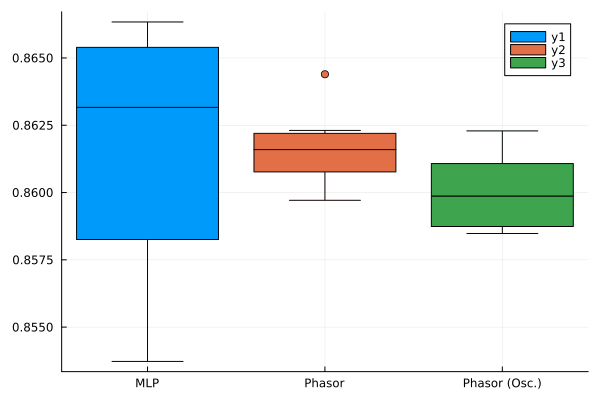

In [24]:
boxplot(stack((auroc_mlps, auroc_pmlps, auroc_pmlp_spks), dims=2))
xticks!([1.0, 2.0, 3.0], ["MLP", "Phasor", "Phasor (Osc.)"])

In [25]:
using HypothesisTests

In [26]:
MannWhitneyUTest(auroc_pmlps, auroc_pmlp_spks)

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.00172525

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1320

Details:
    number of observations in each group: [6, 6]
    Mann-Whitney-U statistic:             28.0
    rank sums:                            [49.0, 29.0]
    adjustment for ties:                  0.0


In [27]:
function predict_ode(trained)
    params = trained["params"]
    state = trained["state"]
    global q
    global yl
    x_tms = range(start=0.0, stop=1.0, length=size(q, 1)) |> collect
    sa = SpikingArgs()

    pred, _ = ode_model(process_inputs_ode(q, x_tms, yl, sa), params, state)
    return pred
end

predict_ode (generic function with 1 method)

In [28]:
auroc_ode = x -> auroc(x, predict_ode)

#76 (generic function with 1 method)

In [29]:
odes = [load("trained_nns/ode_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (layer_1 = (scale = Float32[0.5355419, 0.6982475, 1.1660694, 0.8414003, 0.6907191, 0.69963336, 0.8056348, 1.2444569, 0.9820672, 0.51326776, 0.3376549, 0.203787, 0.20024703, 1.396189], bias = Float32[-0.046362977, 0.019495774, 0.038520116, 0.4472649, 0.40736058, -0.16248043, -0.09638586, 0.2790477, -0.064980365, -0.01898654, -0.3076137, -0.51615435, -0.3593432, -0.20246935]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.026519319 0.0025367395 … 0.15776274 0.22420433; 0.12915637 0.23942517 … 0.012422733 0.13288532; … ; -0.055402208 0.3991249 … -0.11317738 -0.08592525; -0.13373503 0.14865763 … 0.022444913 -0.13480264], bias = Float32[-0.081324; 0.22691543; … ; 0.0766491; -0.15538977;;])), layer_2 = Float32[], layer_3 = (weight = Float32[-0.2024508 -0.2463429 … -0.26188383 -0.20445359; -0.5395407 0.71579164 … -0.29579166 -0.5552426; 0.11988521 -0.044706948 … 0.31210658 0.3256998], bias_real = Float32[10.756406, 0.5117

In [30]:
auroc_odes = auroc_ode.(odes)

6-element Vector{Float64}:
 0.8565303402116241
 0.8574997719668821
 0.8555462326924702
 0.8551482698576797
 0.8560718452261529
 0.8528450413312252

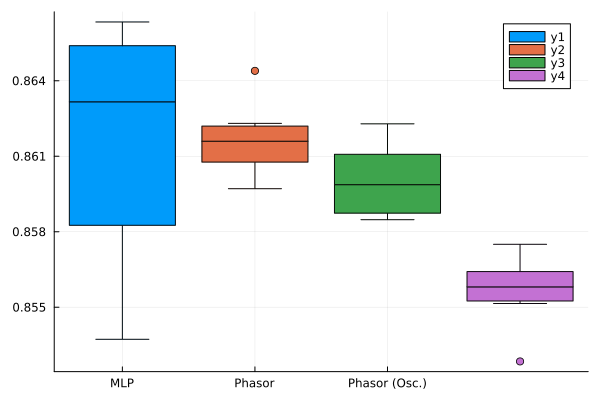

In [33]:
boxplot(stack((auroc_mlps, auroc_pmlps, auroc_pmlp_spks, auroc_odes), dims=2))
xticks!([1.0, 2.0, 3.0], ["MLP", "Phasor", "Phasor (Osc.)", "Phasor-ODE"])